[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/kadenze-deeplearning-creative-applications/blob/master/Kadenze_Session_3.ipynb)

In [0]:
%matplotlib inline
#%pylab

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.style.use('ggplot')

In [2]:
!git clone https://github.com/JacksonIsaac/CADL.git
!mv CADL/session-3/* .

Cloning into 'CADL'...
remote: Counting objects: 2074, done.
remote: Total 2074 (delta 0), reused 0 (delta 0), pack-reused 2074
Receiving objects: 100% (2074/2074), 322.71 MiB | 38.96 MiB/s, done.
Resolving deltas: 100% (1032/1032), done.


In [0]:
from libs.utils import montage
from libs import gif
from libs.datasets import MNIST

In [4]:
ds = MNIST()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
ds.X.shape

(70000, 784)

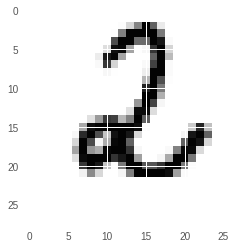

In [6]:
plt.imshow(ds.X[0].reshape((28,28)))

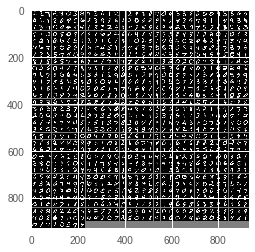

In [7]:
imgs = ds.X[:1000].reshape((-1, 28, 28))
plt.imshow(montage(imgs), cmap='gray')

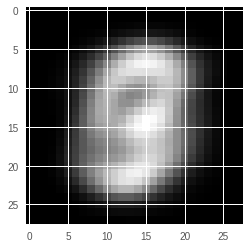

In [8]:
mean_img = np.mean(ds.X, axis=0)
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')

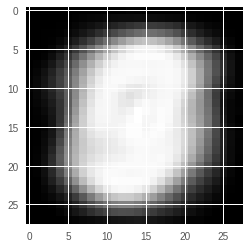

In [9]:
std_img = np.std(ds.X, axis=0)
plt.figure()
plt.imshow(std_img.reshape((28, 28)), cmap='gray')

In [0]:
dimensions = [512, 256, 128, 64]

In [11]:
n_features = ds.X.shape[1]

## [None, n] means that it can have any no of rows m
X = tf.placeholder(tf.float32, [None, n_features])

current_input = X
n_input = n_features


## For Encoder
Ws = []

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        
        W = tf.get_variable(
            name = 'W',
            shape = [n_input, n_output],
            initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws = Ws[::-1]

dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]

print(dimensions)

## Decoder

for layer_i, n_output in enumerate(dimensions):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        
        W = tf.transpose(Ws[layer_i])
        
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output

[128, 256, 512, 784]


In [12]:
Y = current_input

cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

print(cost.get_shape())

(?,)


0 0.044552326
1 0.039032694
2 0.034451783
3 0.032447733
4 0.030514143
5 0.030602163
6 0.029294284
7 0.029392514
8 0.028859029
9 0.028345073


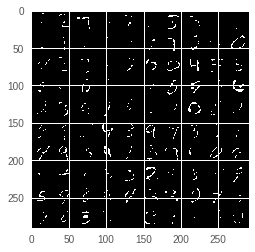

In [13]:
cost = tf.reduce_mean(cost)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 100
n_epochs = 10

examples = ds.X[:100]

imgs = []

fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28,28)), 0, 255)
    
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    
    ax.imshow(img_i, cmap='gray')
    
    fig.canvas.draw()
    
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
    
#gif.build_gif(imgs, saveto='ae.gif', cmap='gray')

In [0]:
#import IPython.display as ipyd
#ipyd.Image(url='ae.gif?{}'.format(np.random.rand()),
#           height=500, width=500)

In [0]:
from tensorflow.python.framework.ops import reset_default_graph

In [0]:
reset_default_graph()

In [17]:
X = tf.placeholder(tf.float32, [None, n_features])

## Reshape placeholder to 4d for convolutional input
## Batch dimension will be filled in place of -1 and
## the shape of the image remains constant.
X_tensor = tf.reshape(X, [-1, 28, 28, 1])

n_filters = [16, 16, 16]
filter_size = [4, 4, 4]

current_input = X_tensor

n_input = 1 # Number of channels in an image

# Will use convolution to find 16 filters/channels of information
Ws = []
shapes = []

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope('encoder/layer/{}'.format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(
            name='W',
            shape=[
                filter_size[layer_i], # height
                filter_size[layer_i], # width
                n_input, # No. of input channels
                n_output # No. of output channels
            ],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        )
        
        # [1, 2, 2, 1]
        # [batch_dimension, next height, next width, #channel]
        # Take every image. Apply to every other height and width. 
        # Apply to every channel.
        
        h = tf.nn.conv2d(current_input, W, strides=[1, 2, 2, 1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output
        
Ws.reverse()
shapes.reverse()
n_filters.reverse()

n_filters = n_filters[1:] + [1]

print(n_filters, filter_size, shapes)

for layer_i, shape in enumerate(shapes):
    with tf.variable_scope('decoder/layer/{}'.format(layer_i)):
        W = Ws[layer_i]
        
        h = tf.nn.conv2d_transpose(
            current_input, W,
            tf.stack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=[1, 2, 2, 1], padding='SAME'
        )
        
        current_input = tf.nn.relu(h)

[16, 16, 1] [4, 4, 4] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]


Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 0.026817413
1 0.025753872
2 0.02484877
3 0.024962569
4 0.02444536
5 0.02388221
6 0.024723776
7 0.023835815
8 0.024841297
9 0.023660423


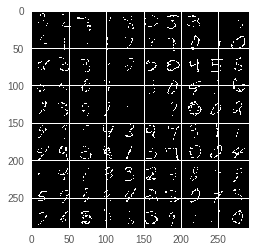

In [18]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

batch_size = 100
n_epoch = 10

examples = ds.X[:100]

imgs = []
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_X - mean_img})
    recon = sess.run(Y, feed_dict={X: examples - mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28, 28)), 0, 255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_img}))
#gif.build_gif(imgs, saveto='conv-ae.gif', cmap='gray')

In [0]:
from libs import datasets

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
5
9
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


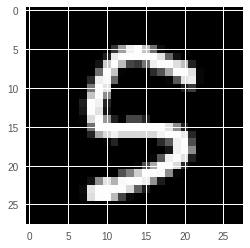

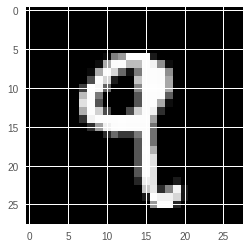

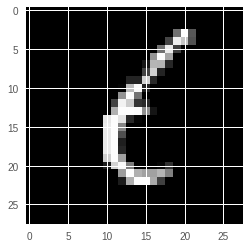

In [20]:
ds = datasets.MNIST(one_hot=False)
print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')

plt.figure()

print(ds.Y[1])
plt.imshow(np.reshape(ds.X[1], (28, 28)), cmap='gray')

ds = datasets.MNIST(one_hot=True)

plt.figure()

print(ds.Y[0])
plt.imshow(np.reshape(ds.X[0], (28, 28)), cmap='gray')

In [0]:
from libs import utils

In [22]:
reset_default_graph()

ds = datasets.MNIST(one_hot=True, split=[0.8, 0.1, 0.1])

n_input = 28 * 28 # Input image dimensions
n_output = 10 # 10 One-hot encoded output labels

X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_output])

## utils.linear returns weight, predictions.
## Hence, For Y_pred we have used utils.linear(...)[0]
Y_pred, W = utils.linear(
    x=X,
    n_output=n_output,
    activation=tf.nn.softmax,
    name='layer1')

## Take log of Y_pred + Epsilon, where epsilon is very small number.
## This makes sure that we are not taking log(0).
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))

learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

predicted_y = tf.argmax(Y_pred, 1)
actual_y = tf.argmax(Y, 1)

correct_prediction = tf.equal(predicted_y, actual_y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 50
n_epochs = 10

## Training
for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs, Y: batch_ys
        })
    valid = ds.valid
    print(sess.run(accuracy,
                  feed_dict={
                      X: valid.images,
                      Y: valid.labels
                  }))

## Testing accuracy
test = ds.test
print(sess.run(accuracy,
              feed_dict={
                  X: test.images,
                  Y: test.labels
              }))

0.901
0.9137143
0.9168571
0.92085713
0.92214286
0.92228574
0.9244286
0.9232857
0.9252857
0.924
0.91814286


In [24]:
g = tf.get_default_graph()
[op.name for op in g.get_operations()]

['Placeholder',
 'Placeholder_1',
 'layer1/W/Initializer/random_uniform/shape',
 'layer1/W/Initializer/random_uniform/min',
 'layer1/W/Initializer/random_uniform/max',
 'layer1/W/Initializer/random_uniform/RandomUniform',
 'layer1/W/Initializer/random_uniform/sub',
 'layer1/W/Initializer/random_uniform/mul',
 'layer1/W/Initializer/random_uniform',
 'layer1/W',
 'layer1/W/Assign',
 'layer1/W/read',
 'layer1/b/Initializer/Const',
 'layer1/b',
 'layer1/b/Assign',
 'layer1/b/read',
 'layer1/MatMul',
 'layer1/h',
 'layer1/Softmax',
 'add/y',
 'add',
 'Log',
 'mul',
 'Const',
 'Sum',
 'Neg',
 'gradients/Shape',
 'gradients/grad_ys_0',
 'gradients/Fill',
 'gradients/Neg_grad/Neg',
 'gradients/Sum_grad/Reshape/shape',
 'gradients/Sum_grad/Reshape',
 'gradients/Sum_grad/Shape',
 'gradients/Sum_grad/Tile',
 'gradients/mul_grad/Shape',
 'gradients/mul_grad/Shape_1',
 'gradients/mul_grad/BroadcastGradientArgs',
 'gradients/mul_grad/Mul',
 'gradients/mul_grad/Sum',
 'gradients/mul_grad/Reshape',
 '

In [0]:
W = g.get_tensor_by_name('layer1/W:0')

In [0]:
W_arr = np.array(W.eval(session=sess))

In [27]:
print(W_arr.shape)

(784, 10)


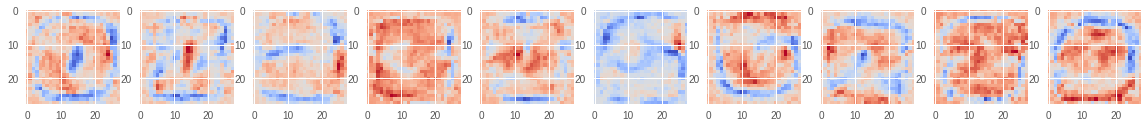

In [28]:
fig, ax = plt.subplots(1, 10, figsize=(20, 3))
for col_i in range(10):
    ax[col_i].imshow(W_arr[:, col_i].reshape((28, 28)), cmap='coolwarm')


In [29]:
reset_default_graph()

g = tf.get_default_graph()
print([op.name for op in g.get_operations()])

[]


In [30]:
mnist = datasets.MNIST(one_hot = True)

n_inputs = 28 * 28
n_outputs = 10

X = tf.placeholder(tf.float32, [None, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_outputs])

## For convlution NN we require 4D 
## N * H * W * Ch
X_4d = tf.reshape(X, [-1, 28, 28, 1])

filter_size = 5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
## Layer 1

n_filters_in = 1 # One channel as input
n_filters_out = 32 # 32 filters (channels of information as output)

W_1 = tf.get_variable(
    name='W',
    # shape = [Height, width, no of input channels, no of output channels]
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

## Input image will be down-sized by 2 when we set strides as 2 i.e., 1,2,2,1

## bias is size of no of output channels since we will apply bias after
## the convolution is performed.
b_1 = tf.get_variable(name='b',
                     shape=[n_filters_out],
                     initializer=tf.constant_initializer())

h_1 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(
            input=X_4d,
            filter=W_1,
            strides=[1, 2, 2, 1],
            padding='SAME'),
    b_1))

In [0]:
## Layer 2

n_filters_in = 32 # Output of previous layer
n_filters_out = 64

W_2 = tf.get_variable(
    name='W2',
    # shape = [Height, width, no of input channels, no of output channels]
    shape=[filter_size, filter_size, n_filters_in, n_filters_out],
    initializer=tf.random_normal_initializer())

## Input image will be down-sized by 2 when we set strides as 2 i.e., 1,2,2,1

## bias is size of no of output channels since we will apply bias after
## the convolution is performed.
b_2 = tf.get_variable(name='b2',
                     shape=[n_filters_out],
                     initializer=tf.constant_initializer())

h_2 = tf.nn.relu(
    tf.nn.bias_add(
        tf.nn.conv2d(
            input=h_1,
            filter=W_2,
            strides=[1, 2, 2, 1],
            padding='SAME'),
    b_2))

In [0]:
## Fully Connected Layer 

## Convert 4d to 2d to connect to the FC layer

h_2_flat = tf.reshape(h_2, [-1, 7 * 7 * n_filters_out])

h_3, W = utils.linear(h_2_flat, 128, activation=tf.nn.relu, name='fc_1')
Y_pred, W = utils.linear(h_3, n_outputs, activation=tf.nn.softmax, name='fc_2')

In [0]:
cross_entropy = -tf.reduce_sum(Y * tf.log(Y_pred + 1e-12))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [39]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 50
n_epochs = 10

for epoch_i in range(n_epochs):
    for batch_xs, batch_ys in ds.train.next_batch():
        sess.run(optimizer, feed_dict={
            X: batch_xs, Y: batch_ys
        })

    valid = ds.valid
    print(sess.run(accuracy, 
                  feed_dict={
                      X: valid.images,
                      Y: valid.labels
                  }))
    
test = ds.test
print(sess.run(accuracy,
              feed_dict={
                  X: test.images,
                  Y: test.labels
              }))

0.9465714
0.9612857
0.967
0.96742857
0.9722857
0.967
0.97171426
0.969
0.97057146
0.97171426
0.9712857


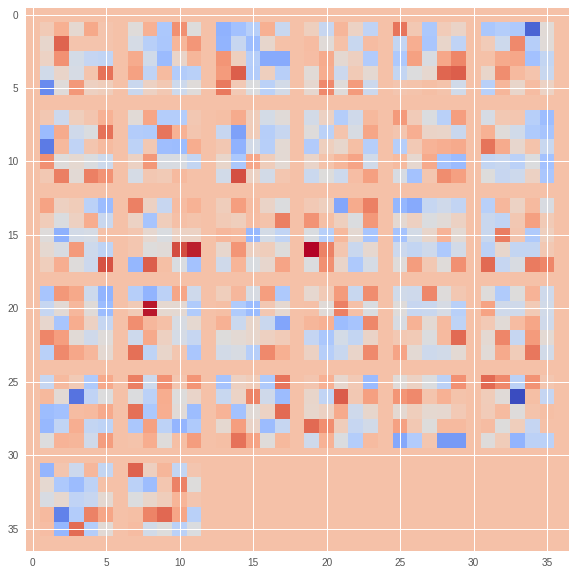

In [40]:
from libs.utils import montage_filters

W1 = sess.run(W_1)
plt.figure(figsize=(10, 10))

plt.imshow(montage_filters(W1), cmap='coolwarm', interpolation='nearest')

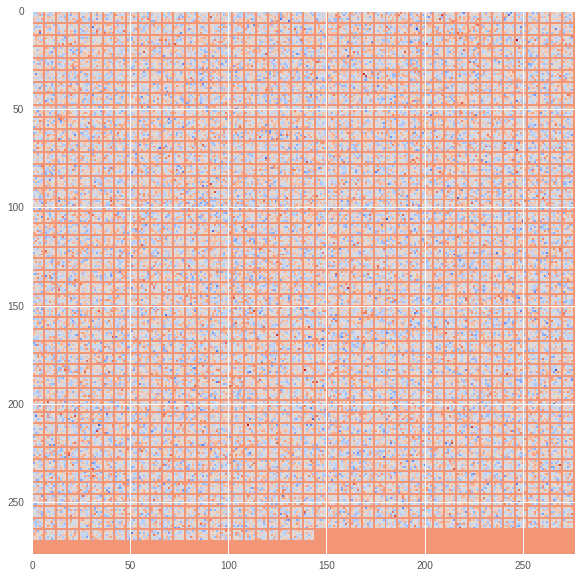

In [43]:
W2 = sess.run(W_2)
plt.figure(figsize=(10, 10))

plt.imshow(montage_filters(W2 / np.max(W2)), cmap='coolwarm')


## Saving and loading networks using checkpoints

In [0]:
import os

In [0]:
sess = tf.Session()

init_op = tf.global_variables_initializer()

saver = tf.train.Saver()

sess.run(init_op)

if os.path.exists('model.ckpt'):
    saver.restore(sess, 'model.ckpt')
    print('Model Restored')

In [49]:
save_path = saver.save(sess, './model.ckpt')
print('Model saved in %s' %save_path)

Model saved in ./model.ckpt
